In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime

import os
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from glob import glob

import torch
import torchvision
import torch.distributed as dist
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from collections import defaultdict, deque

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -uq '/content/drive/MyDrive/Detection_of_lesions/data.zip' -d '/content'

In [4]:
train_files = sorted(glob('/content/train/*')) # 파일의 경로를 가져옴
# test_files = sorted(glob('/content/test/*'))

In [5]:
if len(train_files) == 62622:
  print('데이터를 정상적으로 불러왔습니다.')
else:
  print('데이터 길이에 문제가 있습니다.')

# if len(test_files) == 20874:
#   print('데이터를 정상적으로 불러왔습니다.')
# else:
#   print('데이터 길이에 문제가 있습니다.')

데이터를 정상적으로 불러왔습니다.


In [ ]:
train_json_list = []
train_ap = train_json_list.append # append 뒤가 비어있는 이유는 3번째 아래에서 뒤에 append 뒤에 들어
for file in tqdm(train_files):
    with open(file, "r") as json_file:
        train_ap(json.load(json_file)) #json.load 문자열을 딕셔너리 형태로 바꿔줌.

# test_json_list = []
# test_ap = test_json_list.append
# for file in tqdm(test_files):
#     with open(file, "r") as json_file:
#         test_ap(json.load(json_file))

 10%|█         | 6288/62622 [00:00<00:07, 7740.03it/s]

In [ ]:
train_json_list[0]['shapes'][0]['label']

In [ ]:
ulcer = []
mass = []
lymph = []
bleeding = []
somethingwrong = []

for i in range(len(train_json_list)):
  if train_json_list[i]['shapes'][0]['label'] == '01_ulcer':
    ulcer.append(train_json_list[i])
  elif train_json_list[i]['shapes'][0]['label'] == '02_mass':
    mass.append(train_json_list[i])
  elif train_json_list[i]['shapes'][0]['label'] == '04_lymph':
    lymph.append(train_json_list[i])
  elif train_json_list[i]['shapes'][0]['label'] == '05_bleeding':
    bleeding.append(train_json_list[i])
  else:
    somethingwrong.append(train_json_list[i])
  
  

In [ ]:
print('ulcer :',len(ulcer))
print('mass :',len(mass))
print('lymph :',len(lymph))
print('bleeding :',len(bleeding))
print('total :',len(ulcer) + len(mass) + len(lymph) + len(bleeding))
len(train_json_list)

In [ ]:
data_li = [ulcer, mass, lymph, bleeding]
b_data = []
for i in data_li:
  for z in range(8597):
    b_data.append([z])

In [ ]:
len(b_data) # 균등 데이터 수

In [ ]:
len(train_json_list) # 불균등 데이터 수

In [ ]:
from sklearn.model_selection import train_test_split
train = []
test = []
val = []

for i in data_li:
  X_train, X_test, y_train, y_test = train_test_split(i, i, test_size=0.2, random_state=1)
  test.append(X_test)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
  train.append(X_train)
  val.append(X_val)
  

In [ ]:
print(len(train))
print(len(test))
print(len(val))

In [ ]:
len(X_train)


In [ ]:
len(X_val)

In [ ]:
len(X_test)

In [ ]:
import itertools
train = list(itertools.chain(*train))
test = list(itertools.chain(*test))
val = list(itertools.chain(*val))

In [ ]:
print(len(train))
print(len(test))
print(len(val))
train[0]

In [ ]:
train_list = train
test_list = test

In [ ]:
label_count = {}
for data in train_list:
    for shape in data['shapes']:
        try:
            label_count[shape['label']]+=1
        except:
            label_count[shape['label']]=1

In [ ]:
label_count

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


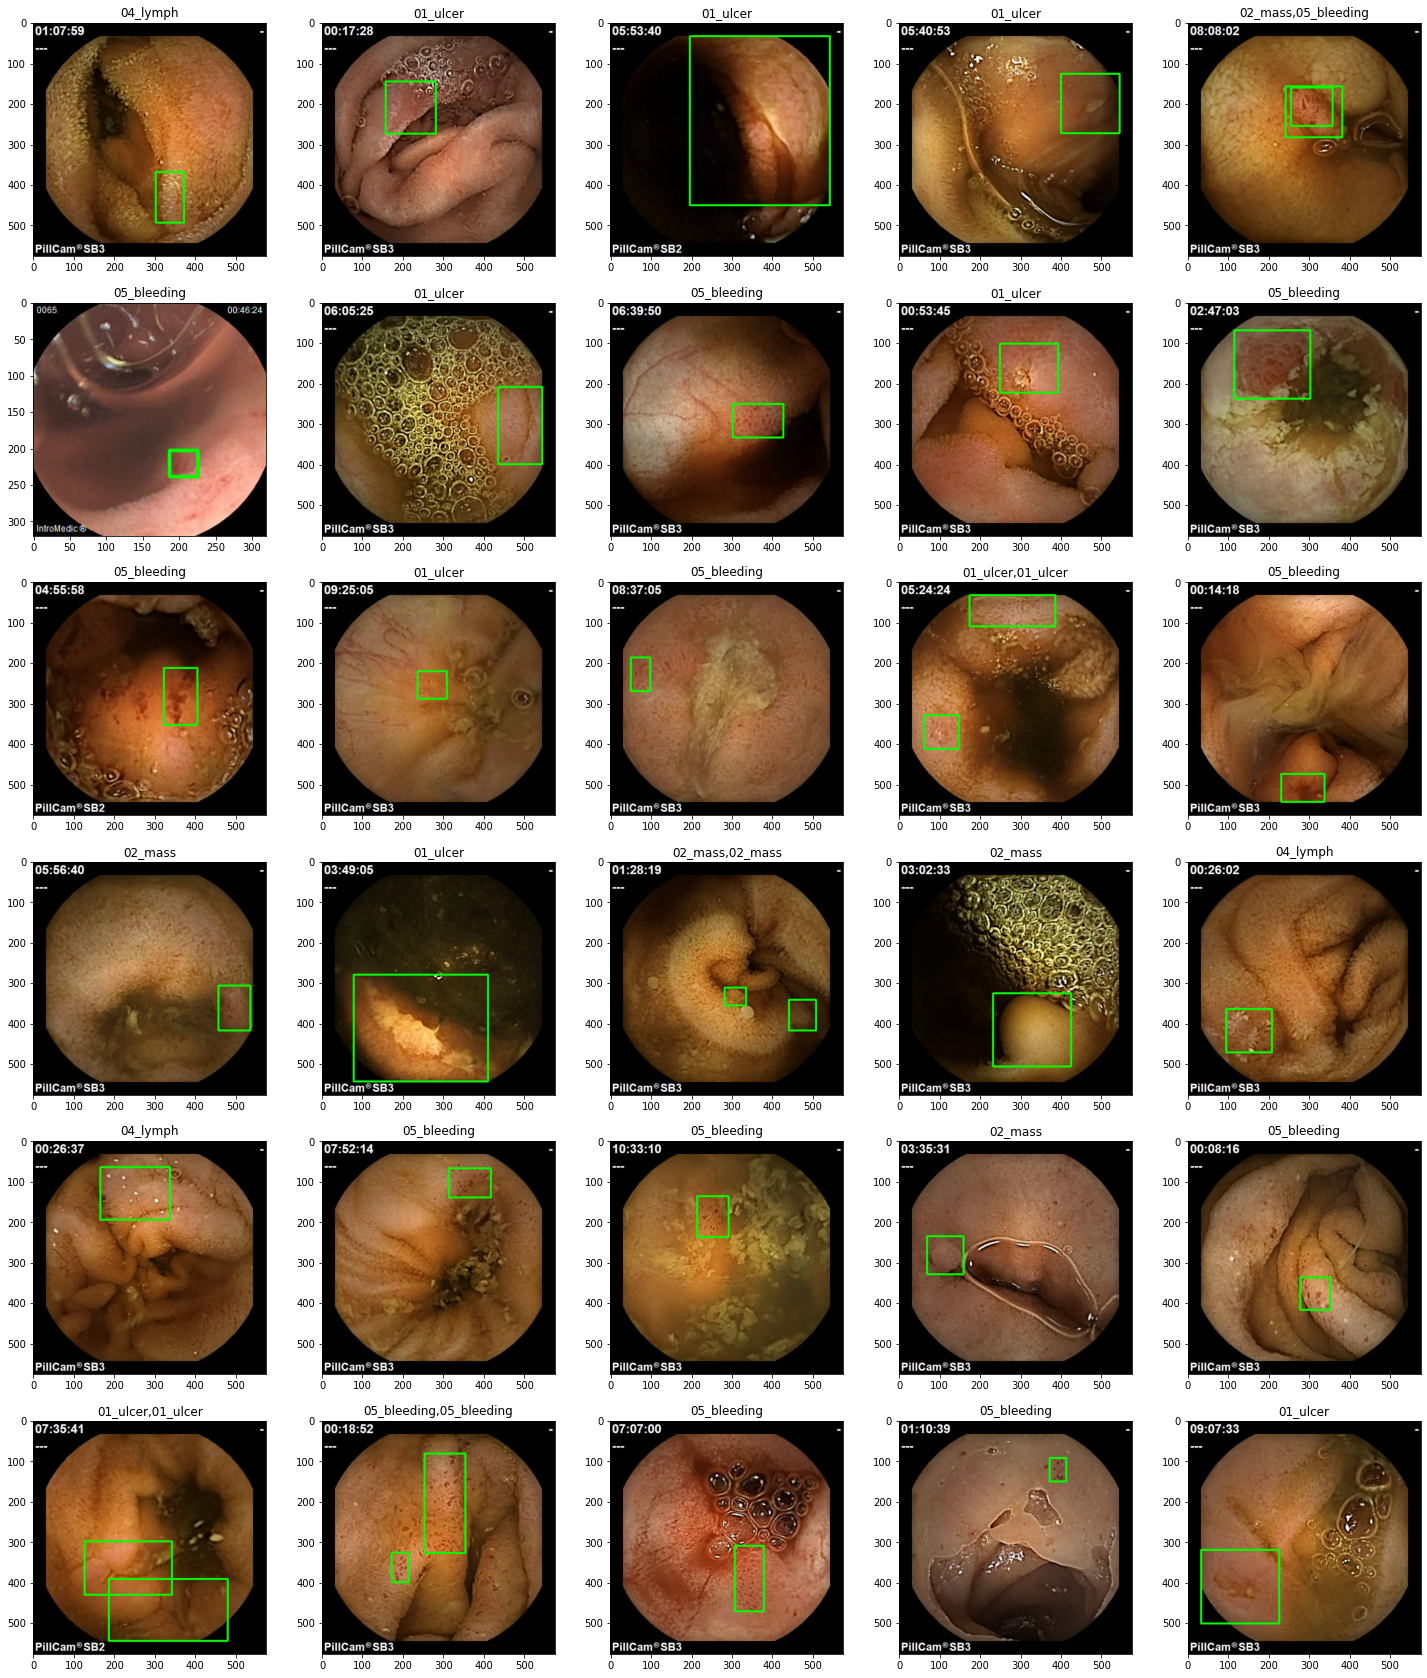

In [ ]:
plt.figure(figsize=(25,30))
for i in range(30):
    plt.subplot(6,5,i+1)
    # base64 형식을 array로 변환
    img = Image.open(BytesIO(base64.b64decode(train_json_list[i]['imageData'])))
    img = np.array(img, np.uint8)
    title = []
    for shape in train_json_list[i]['shapes']:
        points = np.array(shape['points'], np.int32)
        cv2.polylines(img, [points], True, (0,255,0), 3)
        title.append(shape['label'])
    title = ','.join(title)
    plt.imshow(img)
    plt.subplot(6,5,i+1).set_title(title)
plt.show()

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, json_list, mode='train'):
        self.mode = mode
        self.file_name = [json_file['file_name'] for json_file in json_list]
        if mode == 'train':
            self.labels = []
            for data in json_list:
                label = []
                for shapes in data['shapes']:
                    label.append(shapes['label'])
                self.labels.append(label)
            self.points = []
            for data in json_list:
                point = []
                for shapes in data['shapes']:
                    point.append(shapes['points'])
                self.points.append(point)
        self.imgs = [data['imageData'] for data in json_list]
        
        self.widths = [data['imageWidth'] for data in json_list]
        self.heights = [data['imageHeight'] for data in json_list]
        
        self.label_map ={
            '01_ulcer':1, '02_mass':2, '04_lymph':3, '05_bleeding':4
        }
        
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        file_name = self.file_name[i]
        img = Image.open(BytesIO(base64.b64decode(self.imgs[i])))
        img = self.transforms(img)

        target = {}
        if self.mode == 'train':
            boxes = []
            for point in self.points[i]:
                x_min = int(np.min(np.array(point)[:,0]))
                x_max = int(np.max(np.array(point)[:,0]))
                y_min = int(np.min(np.array(point)[:,1]))
                y_max = int(np.max(np.array(point)[:,1]))
                boxes.append([x_min, y_min, x_max, y_max])
            boxes = torch.as_tensor(boxes, dtype=torch.float32)

            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

            label = [self.label_map[label] for label in self.labels[i]]

            masks = []
            for box in boxes:
                mask = np.zeros([int(self.heights[i]), int(self.widths[i])], np.uint8)
                masks.append(cv2.rectangle(mask, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), 1, -1))

            masks = torch.tensor(masks, dtype=torch.uint8)

            target["boxes"] = boxes
            target["labels"] = torch.tensor(label, dtype=torch.int64)
            target["masks"] = masks
            target["area"] = area
            target["iscrowd"] = iscrowd
        target["image_id"] = torch.tensor([i], dtype=torch.int64)
        if self.mode == 'test':
            target["file_name"] = file_name
        return img, target

In [ ]:
train_dataset = CustomDataset(train_list, mode='train')
test_dataset = CustomDataset(test_list, mode='test')

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dataset = CustomDataset(train_json_list, mode='train')

torch.manual_seed(1)
indices = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, indices)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=16,
    collate_fn=collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# class 4 + background 1 = 5
num_classes = 5

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)
    
class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))
        
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

In [ ]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset

In [ ]:
threshold = 0.5 # confidence 값
results = {
    'file_name':[], 'class_id':[], 'confidence':[], 'point1_x':[], 'point1_y':[],
    'point2_x':[], 'point2_y':[], 'point3_x':[], 'point3_y':[], 'point4_x':[], 'point4_y':[]
}
model.eval()
for img, target in tqdm(test_dataset):
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    
    idx = np.where(prediction['scores'].cpu().numpy() > threshold)[0]
    for i in idx:
        x_min, y_min, x_max, y_max = prediction['boxes'].cpu().numpy()[i]
        class_id = prediction['labels'].cpu().numpy()[i]
        confidence = prediction['scores'].cpu().numpy()[i]
        
        results['file_name'].append(target['file_name'])
        results['class_id'].append(class_id)
        results['confidence'].append(confidence)
        results['point1_x'].append(x_min)
        results['point1_y'].append(y_min)
        results['point2_x'].append(x_max)
        results['point2_y'].append(y_min)
        results['point3_x'].append(x_max)
        results['point3_y'].append(y_max)
        results['point4_x'].append(x_min)
        results['point4_y'].append(y_max)

In [ ]:
submission = pd.DataFrame(results)

submission.to_csv(f'/content/drive/MyDrive/Detection_of_lesions/code/Faster_RCNN/submission_FRCNN_base_epoch_{num_epochs}_{threshold}.csv', index=False)

In [ ]:
# save
torch.save(model.state_dict(),f'/content/drive/MyDrive/Detection_of_lesions/code/Faster_RCNN/model_base_epoch_{num_epochs}_{threshold}.pt')


In [ ]:
!python /content/drive/MyDrive/Detection_of_lesions/code/Faster_RCNN/eval_detection_voc.py -answer /content/drive/MyDrive/Detection_of_lesions/code/Faster_RCNN/gts_df.csv -data /content/drive/MyDrive/Detection_of_lesions/code/Faster_RCNN/submission_FRCNN_base_epoch_{num_epochs}_{threshold}.csv

In [ ]:
# ### Load saved model test

# num_classes = 5

# # get the model using our helper function
# model2 = get_instance_segmentation_model(num_classes)
# # move model to the right device
# model2.to(device)


In [ ]:
# # load

# model2.load_state_dict(torch.load(f'/content/drive/MyDrive/Detection_of_lesions/code/Faster_RCNN/model.pt'))